In [20]:
try:
    # Import necessary libraries
    import os
    import requests
    import logging
    from typing import Dict, List, Optional, Set, Tuple
    from collections import defaultdict
    from IPython.display import display
    import requests
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import folium
    from geopy.distance import geodesic
    from dotenv import load_dotenv

    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger(__name__)

    load_dotenv('../Docs/.env')
    app_key = os.getenv('app_key')

    if not app_key:
        logger.error("No TfL API key found")

except Exception as e:
    print(f"Error : {e}")

In [21]:
base_url = 'https://api.tfl.gov.uk'

# Get all stations and their information
# Official TfL line colors
line_colors = {
    'bakerloo': '#B36305',
    'central': '#E32017',
    'circle': '#FFD300',
    'district': '#00782A',
    'hammersmith-city': '#F3A9BB',
    'jubilee': '#A0A5A9',
    'metropolitan': '#9B0056',
    'northern': '#000000',
    'piccadilly': '#003688',
    'victoria': '#0098D4',
    'waterloo-city': '#95CDBA'
}

# Station colors
station_colors = {
    'regular': 'white',
    'interchange': 'grey',
    'edge': 'black'
}

In [22]:
# Fetch stations
try:
    response = requests.get(
        'https://api.tfl.gov.uk/StopPoint/Mode/tube',
        params={'app_key': app_key}
    )
    response.raise_for_status()
    stations = response.json()
except requests.RequestException as e:
    logger.error(f"Error fetching station data: {e}")
    stations = None

# Fetch lines
try:
    response = requests.get(
        'https://api.tfl.gov.uk/Line/Mode/tube',
        params={'app_key': app_key}
    )
    response.raise_for_status()
    lines = response.json()
except requests.RequestException as e:
    logger.error(f"Error fetching line data: {e}")
    lines = None

In [23]:
# Initialize data structures
station_lines = defaultdict(set)
line_stations = defaultdict(set)

# Process stations
valid_stations = {}
for station in stations['stopPoints']:
    if station['stopType'] == 'NaptanMetroStation' and 'tube' in station['modes']:
        station_id = station['naptanId']
        valid_stations[station_id] = {
            'name': station['commonName'],
            'lat': station['lat'],
            'lon': station['lon']
        }

# Process lines and their stations
for line in lines:
    line_id = line['id']
    try:
        response = requests.get(
            f'https://api.tfl.gov.uk/Line/{line_id}/Route/Sequence/all',
            params={'app_key': app_key}
        )
        response.raise_for_status()
        line_data = response.json()

        if 'orderedLineRoutes' in line_data:
            for route in line_data['orderedLineRoutes']:
                for station_id in route['naptanIds']:
                    if station_id in valid_stations:
                        station_lines[station_id].add(line_id)
                        line_stations[line_id].add(station_id)
    except requests.RequestException as e:
        logger.warning(f"Error fetching data for line {line_id}: {e}")

# Filter lines with at least 5 stations
valid_lines = {
    line_id: stations
    for line_id, stations in line_stations.items()
    if len(stations) >= 5
}

# Select top 5 lines with most stations
if len(valid_lines) >= 5:
    selected_lines = dict(
        sorted(valid_lines.items(), key=lambda x: len(x[1]), reverse=True)[:5]
    )

    # Get stations for selected lines
    selected_stations = set()
    for stations_set in selected_lines.values():
        selected_stations.update(stations_set)

    analysis = {
        'stations': {
            station_id: {
                **valid_stations[station_id],
                'lines': station_lines[station_id]
            }
            for station_id in selected_stations
        },
        'lines': selected_lines,
        'stats': {
            'num_stations': len(selected_stations),
            'num_lines': len(selected_lines),
            'lines_info': {
                line: len(stations)
                for line, stations in selected_lines.items()
            }
        }
    }
else:
    logger.error("Insufficient data meeting requirements")
    analysis = None

In [24]:
# Initialize the graph
G = nx.Graph()

# Add stations to the graph
for station_id, station_data in analysis['stations'].items():
    station_name = station_data['name'].replace(" Underground Station", "")
    G.add_node(
        station_id,
        name=station_name,
        pos=(station_data['lon'], station_data['lat']),
        lines=station_data['lines']
    )

# Add connections between stations
for line_id in analysis['lines'].keys():
    try:
        response = requests.get(
            f'https://api.tfl.gov.uk/Line/{line_id}/Route/Sequence/all',
            params={'app_key': app_key}
        )
        response.raise_for_status()
        line_data = response.json()

        if 'orderedLineRoutes' in line_data:
            for route in line_data['orderedLineRoutes']:
                stations_list = route['naptanIds']
                for i in range(len(stations_list) - 1):
                    start_station = stations_list[i]
                    end_station = stations_list[i + 1]
                    if (G.has_node(start_station)
                        and G.has_node(end_station)
                        and not G.has_edge(start_station, end_station)):

                        # Calculate distance between stations
                        start_pos = G.nodes[start_station]['pos']
                        end_pos = G.nodes[end_station]['pos']
                        distance = geodesic(
                            (start_pos[1], start_pos[0]),
                            (end_pos[1], end_pos[0])
                        ).kilometers

                        # Add edge to the graph
                        G.add_edge(
                            start_station,
                            end_station,
                            line=line_id,
                            color=line_colors.get(line_id.lower(), '#808080'),
                            distance=round(distance, 2)
                        )
    except requests.RequestException as e:
        logger.error(f"Error fetching line data for {line_id}: {e}")

In [25]:
# Log analysis results
logger.info("Network Analysis:")
logger.info("Selected Lines:")
for line, stations in analysis['lines'].items():
    logger.info(f"- {line}: {len(stations)} stations")
logger.info(f"Total Stations: {analysis['stats']['num_stations']}")

Network Analysis:
Selected Lines:
- district: 60 stations
- piccadilly: 53 stations
- northern: 52 stations
- central: 49 stations
- circle: 36 stations
Total Stations: 212


In [26]:
# Create an interactive map centered on London with a clean style and appropriate zoom level
m = folium.Map(
    location=[51.5074, -0.1278],
    zoom_start=12,
    tiles='cartodbpositron'
)

# Add lines to the map with updated styling
for (u, v, data) in G.edges(data=True):
    line_coords = [
        [G.nodes[u]['pos'][1], G.nodes[u]['pos'][0]],
        [G.nodes[v]['pos'][1], G.nodes[v]['pos'][0]]
    ]

    # Create popup content
    popup_html = f"""
        <div style="font-family: Arial, sans-serif;">
            <h4>{data['line']} Line</h4>
            <p>Distance: {data['distance']:.2f} km</p>
            <p>Stations: {G.nodes[u]['name']} → {G.nodes[v]['name']}</p>
        </div>
    """

    # Add the line to the map with updated styling
    folium.PolyLine(
        line_coords,
        color=data['color'],
        weight=4,     # Thicker lines
        opacity=0.9,  # More solid lines
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Add stations to the map with updated styling
for node, data in G.nodes(data=True):
    is_interchange = len(data['lines']) > 1

    # Create popup content
    popup_html = f"""
        <div style="font-family: Arial, sans-serif;">
            <h4>{data['name']}</h4>
            <p>Lines: {', '.join(data['lines'])}</p>
            <p>Type: {'Interchange' if is_interchange else 'Regular'} Station</p>
        </div>
    """

    # Add the station to the map with updated styling
    folium.CircleMarker(
        location=[data['pos'][1], data['pos'][0]],
        radius=8 if is_interchange else 5,
        color='black',
        fill=True,
        fill_color=station_colors['interchange'] if is_interchange else station_colors['regular'],
        weight=2.5 if is_interchange else 1,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# Display the map
display(m)

In [28]:
# Optionally save the map to an HTML file
m.save('TfL-Map.html')

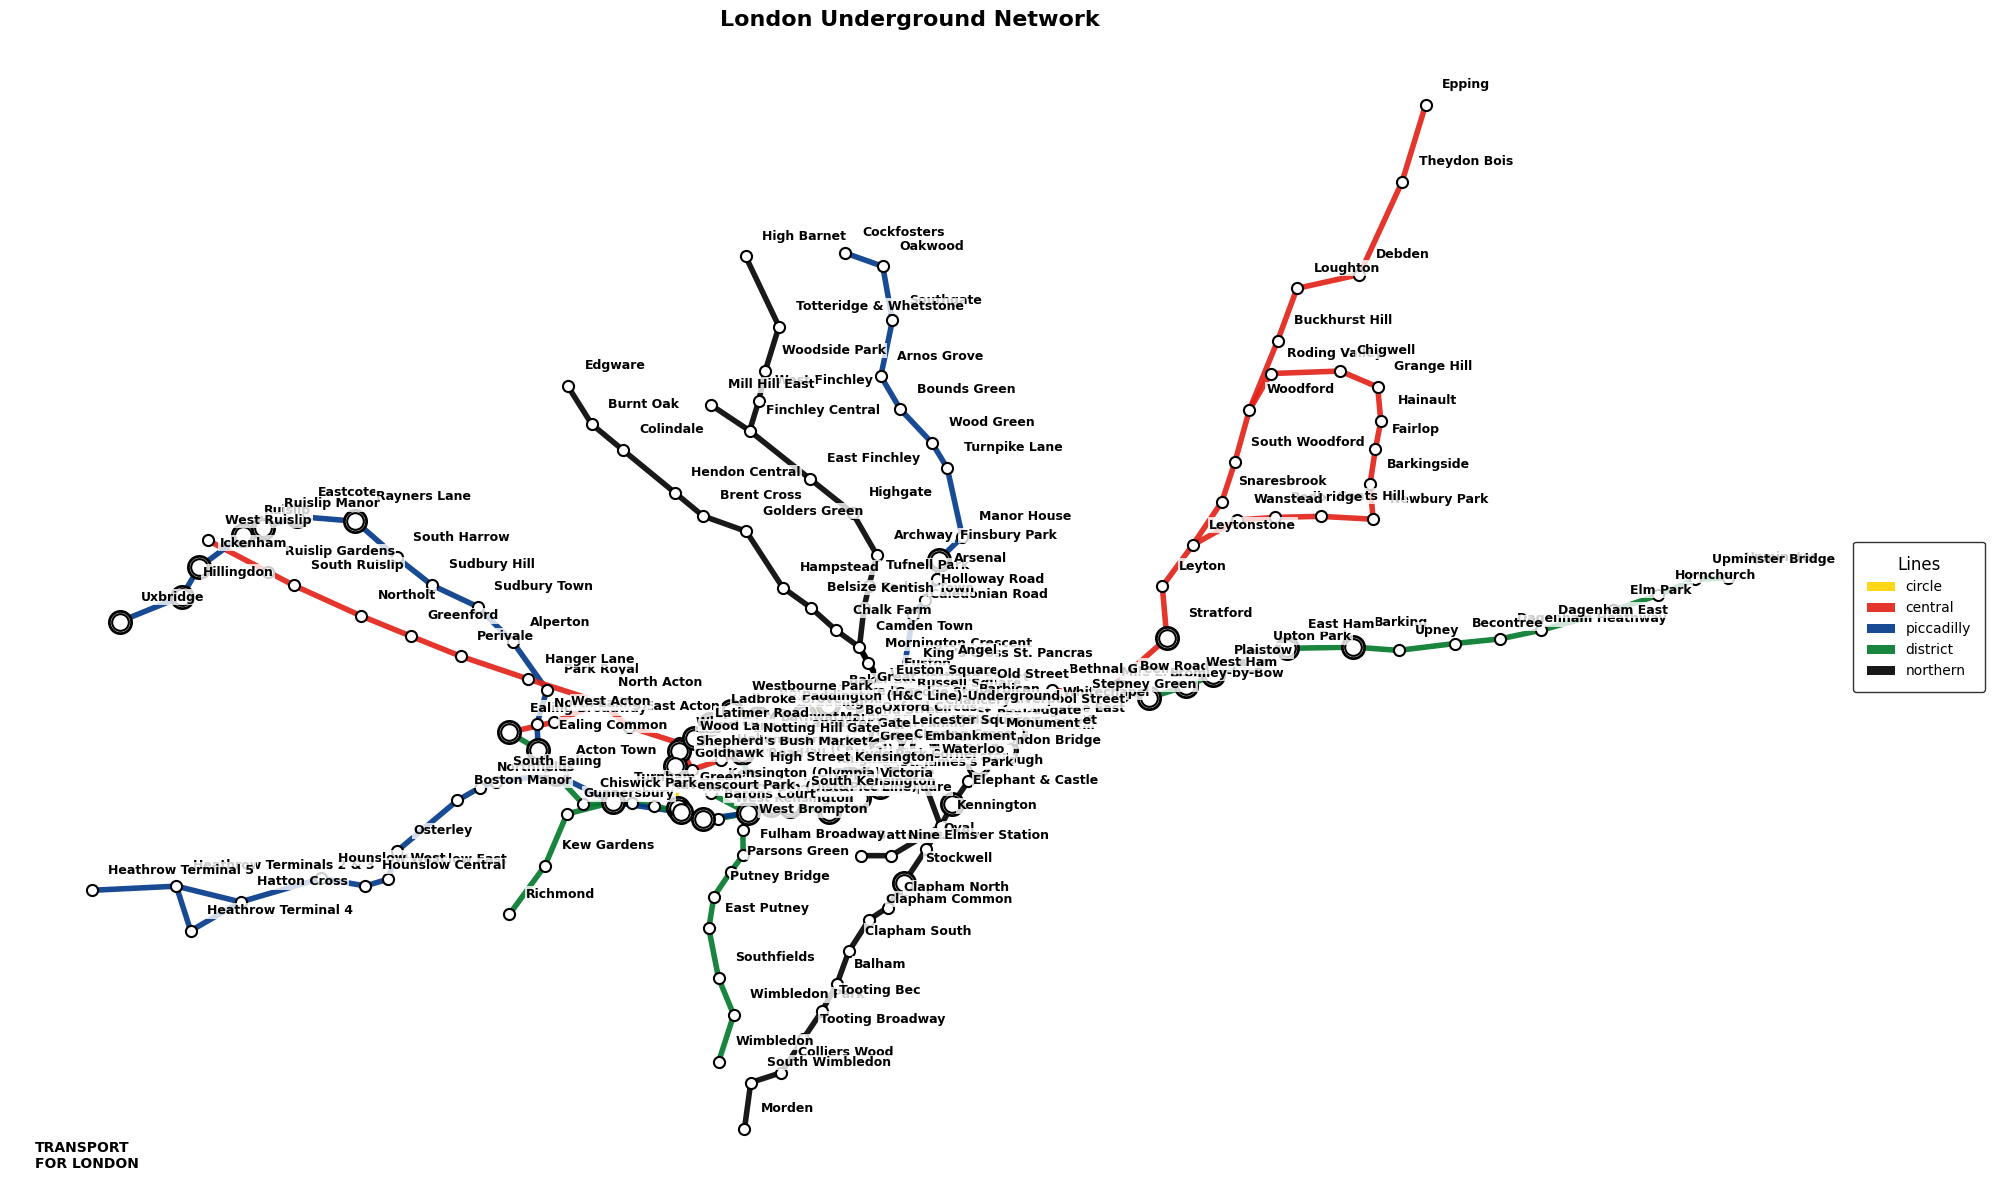

In [29]:
plt.figure(figsize=(20, 12), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# Use geographic coordinates for plotting
pos = {node: data['pos'] for node, data in G.nodes(data=True)}

# Draw edges (lines) with rounded corners
drawn_lines = set()
for (u, v, data) in G.edges(data=True):
    plt.plot(
        [pos[u][0], pos[v][0]],
        [pos[u][1], pos[v][1]],
        color=data['color'],
        linewidth=4,              # Thicker lines
        solid_capstyle='round',   # Rounded line ends
        solid_joinstyle='round',  # Rounded corners
        alpha=0.9,                # More solid lines
        label=data['line'] if data['line'] not in drawn_lines else "",
        zorder=1
    )
    drawn_lines.add(data['line'])

# Draw stations
for node, data in G.nodes(data=True):
    is_interchange = len(data['lines']) > 1
    
    if is_interchange:
        # Draw larger white background circle for interchange stations
        plt.plot(
            data['pos'][0],
            data['pos'][1],
            'o',
            color='white',
            markersize=16,
            markeredgecolor='black',
            markeredgewidth=2,
            zorder=2
        )
        
        # Draw inner circle
        plt.plot(
            data['pos'][0],
            data['pos'][1],
            'o',
            color='white',
            markersize=12,
            markeredgecolor='black',
            markeredgewidth=1.5,
            zorder=3
        )
    else:
        # Regular stations
        plt.plot(
            data['pos'][0],
            data['pos'][1],
            'o',
            color='white',
            markersize=8,
            markeredgecolor='black',
            markeredgewidth=1.5,
            zorder=2
        )

    # Add station labels with TfL-style typography
    label_offset = 15 if is_interchange else 12
    plt.annotate(
        data['name'],
        (data['pos'][0], data['pos'][1]),
        xytext=(label_offset, label_offset),
        textcoords='offset points',
        fontsize=9,
        fontfamily='sans-serif',
        fontweight='bold',
        bbox=dict(
            facecolor='white',
            edgecolor='none',
            alpha=0.8,
            pad=1
        ),
        zorder=4
    )

# Create custom legend with line colors
legend_elements = []
for line_name in drawn_lines:
    line_color = next(
        data['color'] 
        for _, _, data in G.edges(data=True) 
        if data['line'] == line_name
    )
    legend_elements.append(
        patches.Patch(
            facecolor=line_color,
            label=line_name,
            alpha=0.9
        )
    )

# Add legend with TfL-style formatting
plt.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Lines',
    title_fontsize=12,
    fontsize=10,
    frameon=True,
    edgecolor='black',
    facecolor='white',
    borderpad=1
)

plt.title(
    "London Underground Network",
    pad=20,
    fontsize=16,
    fontweight='bold',
    fontfamily='sans-serif'
)

# Add TfL logo text
plt.figtext(
    0.02, 0.02,
    'TRANSPORT\nFOR LONDON',
    fontsize=10,
    fontweight='bold',
    fontfamily='sans-serif',
    va='bottom'
)

plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
# Calculate network statistics
stats = {
    'num_stations': G.number_of_nodes(),
    'num_connections': G.number_of_edges(),
    'num_interchanges': sum(
        1 for _, data in G.nodes(data=True)
        if len(data['lines']) > 1
    ),
    'total_distance': sum(
        data['distance']
        for _, _, data in G.edges(data=True)
    ),
    'is_connected': nx.is_connected(G)
}

# Display network statistics
logger.info("Network Statistics:")
for key, value in stats.items():
    logger.info(f"{key}: {value}")

Network Statistics:
num_stations: 212
num_connections: 230
num_interchanges: 78
total_distance: 272.32
is_connected: True
